In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('adoption_series2.csv')

df = df[['t', 'N(t)']]
df.columns = ['t', 'n_t']


(Q1.1) Estimate "M", "p" and "q" from the adoption series dataset using the linear regression approach described on Slides 8 and 9. From  these values, compute the values of N(t) beyond t=14. Specifically, compute N(30). No writeup necessary, simply state your values of "M", "p", "q" and N(30).

In [239]:
## Code written by me

# Creating adoption series A(t) and A(t)^2
df['a_t'] = df['n_t'].cumsum()
df['a_t'] = df['a_t'].shift(1)
df.fillna(0, inplace=True)

df['a2_t'] = df['a_t']**2

# Fit an ols model
model = ols('n_t ~ a_t + a2_t', data = df).fit()
#print(model.summary())

#Finding p, q, M
a = model.params['Intercept']
b = model.params['a_t']
c = model.params['a2_t']

p = (np.sqrt(b**2 - 4 * a * c) - b)/2
q = (np.sqrt(b**2 - 4 * a * c) + b)/2
M = -q/c

# Adding new rows to the dataframe
for i in range(15, 31):
    df = pd.concat([df, pd.DataFrame({'t': [i], 'n_t': [0], 'a_t': [0], 'a2_t': [0]})], ignore_index=True)
    df.loc[i-1, 'a_t'] = df.loc[i-2, 'n_t'] + df.loc[i-2, 'a_t']
    df.loc[i-1, 'a2_t'] = df.loc[i-1, 'a_t']**2
    df.loc[i-1, 'n_t'] = a + b*df.loc[i-1, 'a_t'] + c*df.loc[i-1, 'a2_t']

# Significant digits
p = float('%.*g' % (3, p))
q = float('%.*g' % (3, q))
M = float('%.*g' % (3, M))
N_30 = float('%.*g' % (3, df.loc[29, 'n_t']))

# Print final deliverable values
print(f'p = {p}, q = {q}, M = {M}, N(30) = {N_30}')

p = 0.00279, q = 0.214, M = 34.4, N(30) = 0.974


In [260]:
## Code generated by ChatGPT3.5 based on the following prompt:

#Write a python code to import a file 'adoption_series2.csv' as a data frame. Select two columns t, N(t). Rename the two columns to t and n_t. This data corresponds to the t and N(t) values for a Discrete Bass Diffusion Model where t is from 0-13. Solve the following questions one by one using the same data frame above and provide the python code for it.
#Starting from A(0) = 0, compute A(t+1) = A(t) + N(t) for the data frame iteratively. Then compute a new column A^2(t). Fit a linear regression model on this data frame with equation n_t ~ a_t + a_t^2. The output coefficients of intercept is a, a_t is b and a_t^2 is c. Calculate p = ((b^2 - 4ac)^0.5 - b)/2, q = ((b^2 - 4ac)^0.5 + b)/2, M = -q/c. Then, iteratively add rows to the data frame with calculated next values of A(t) = A(t-1) + N(t) and N(t) = p*M + (q-p)A(t) - q*A(t)^2/M using p, q, M from the regression till N(30) without using the append function. Print your values of “M”, “p”, “q” and N(30) rounded to 3 significant digits.

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Step 1: Import the CSV file as a DataFrame and select columns t, N(t), and rename them
df = pd.read_csv('adoption_series2.csv', usecols=['t', 'N(t)'])
df.columns = ['t', 'n_t']

# Step 2: Compute A(t+1) = A(t) + N(t) for the data frame iteratively starting from A(0) = 0
df['A_t'] = df['n_t'].cumsum()
df['A_t'] = df['A_t'].shift(1)
df.at[0, 'A_t'] = 0

# Step 3: Compute A^2(t) column
df['A^2_t'] = df['A_t'] ** 2

# Step 4: Fit a linear regression model n_t ~ a_t + a_t^2
X = df[['A_t', 'A^2_t']]
y = df['n_t']

model = LinearRegression()
model.fit(X, y)

# Step 5: Calculate p, q, and M from the regression output
a = model.intercept_
b = model.coef_[0]
c = model.coef_[1]

discriminant = np.sqrt(b**2 - 4 * a * c)
p = (discriminant - b) / 2
q = (discriminant + b) / 2
M = -q / c

# Step 6: Iterate to calculate N(t) till t = 30 and update the DataFrame
for t in range(14, 31):
    A_t = df.at[t - 1, 'A_t'] + df.at[t - 1, 'n_t']
    N_t = p * M + (q - p) * A_t - q * (A_t ** 2) / M
    df.loc[t] = [t, N_t, A_t, A_t ** 2]

# Round the values to 3 significant digits
p = round(p, 3)
q = round(q, 3)
M = round(M, 3)
N_30 = round(df.at[29, 'n_t'], 3)

# Print values of M, p, q, and N(30)
print("M:", M)
print("p:", p)
print("q:", q)
print("N(30):", N_30)

M: 34.405
p: 0.003
q: 0.214
N(30): 0.974


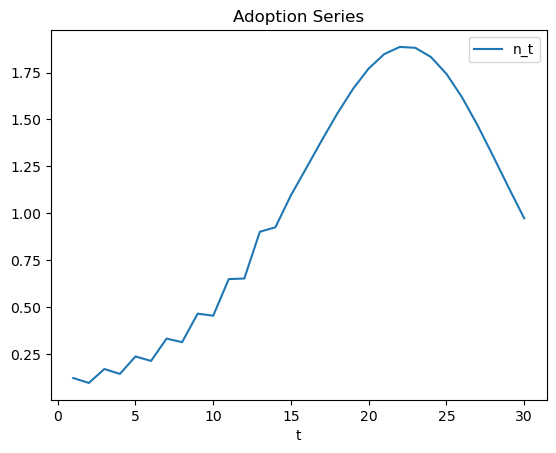

In [87]:
plot = df.plot(x='t', y='n_t', kind='line', title='Adoption Series')

(Q1.2) Assume M is fixed at M=100. Estimate "p" and "q" from the adoption series dataset from period 1 to 14 using the nonlinear regression approach, again based on the formula at the top of slide 8. See Question Q4 below for comments on what makes the model nonlinear when M is fixed, but linear when M is not fixed (as in Q1.1 above).   No writeup necessary, simply state your values of "p", "q" . 

In [271]:
# Load the data
df = pd.read_csv('adoption_series2.csv')

df = df[['t', 'N(t)']]
df.columns = ['t', 'n_t']

# Creating adoption series A(t) and A(t)^2
df['a_t'] = df['n_t'].cumsum()
df['a_t'] = df['a_t'].shift(1)
df.fillna(0, inplace=True)

df['a2_t'] = df['a_t']**2

# Assuming M is fixed at 100
m = 100

# Defining the function
def nt(a_t, p, q):
    return m*p + (q-p)*a_t - q*a_t**2/100

# Applying curve fit
popt, pcov = curve_fit(nt, df.a_t, df.n_t)

# Finding p, q
p = popt[0]
q = popt[1]

# Significant digits
p = float('%.*g' % (3, p))
q = float('%.*g' % (3, q))
m = float('%.*g' % (3, m))

# Print final deliverable values
print(f'p = {p}, q = {q}, M = {m}')

p = 0.00106, q = 0.194, M = 100.0


(Q1.3) Using M=100 and the estimated values of "p" and "q" from Step 2 above, forecast into the future beyond period 14. Compute the value of N(30). No writeup necessary. Simply state the N(30) value that you got. 

In [250]:
# Adding new rows to the dataframe
for i in range(15, 31):
    df = pd.concat([df, pd.DataFrame({'t': [i], 'n_t': [0], 'a_t': [0], 'a2_t': [0]})], ignore_index=True)
    df.loc[i-1, 'a_t'] = df.loc[i-2, 'n_t'] + df.loc[i-2, 'a_t']
    df.loc[i-1, 'a2_t'] = df.loc[i-1, 'a_t']**2
    df.loc[i-1, 'n_t'] = nt(df.loc[i-1, 'a_t'], p, q)

# Significant digits
N_30 = float('%.*g' % (3, df.loc[29, 'n_t']))

# Print final deliverable values
print(f'N(30) = {N_30}')

N(30) = 4.9


(Q1.4) Continue to assume M=100. Estimate "p" and "q" from the adoption series from period 1 to 14, this time using the Continuous Bass Model of  Slide 21.  You can do this via nonlinear regression in python creating a formula based on the expression at the bottom of Slide 21. [Alternatively you can set up an optimization calculation to minimize the Sum of Squared Errors(SSE), like on Slides 23-25, shown in the spreadsheet adoptionseries1_continuous_bass_solved.xls. In this spreadsheet if we start with p=0.001, q=0.5, M=100 (the values you see when you see when you open the spreadsheet), and run SOLVER to optimize for p,q,M, then we get estimates as p=0.000596, q=0.418653, M=123.4005.] For this HW question, because M is already assumed to be M=100, we optimize  for only p and q,  fixing M at 100. Use your estimated values of p and q to estimate the value of N(30) under the Continuous Bass Model. No writeup necessary. Simply state your values of p, q, and N(30). 

In [270]:
# Load the data
df = pd.read_csv('adoption_series2.csv')

df = df[['t', 'N(t)']]
df.columns = ['t', 'n_t']

# Creating adoption series A(t) and A(t)^2
df['a_t'] = df['n_t'].cumsum()
df['a_t'] = df['a_t'].shift(1)
df.fillna(0, inplace=True)

df['a2_t'] = df['a_t']**2

# Assuming M is fixed at 100
m = 100

# Defining the function
def at(t, p, q):
    return m*((1 - np.exp(-(p+q)*t))/(1 + (q/p)*np.exp(-(p+q)*t)))

def nt(t, p, q):
    return at(t, p, q) - at(t-1, p, q)

# Applying curve fit
popt, pcov = curve_fit(nt, df.t, df.n_t)

# Finding p, q
p = popt[0]
q = popt[1]

# Adding new rows to the dataframe
for i in range(15, 31):
    df = pd.concat([df, pd.DataFrame({'t': [i], 'n_t': [0], 'a_t': [0], 'a2_t': [0]})], ignore_index=True)
    df.loc[i-1, 'a_t'] = df.loc[i-2, 'n_t'] + df.loc[i-2, 'a_t']
    df.loc[i-1, 'a2_t'] = df.loc[i-1, 'a_t']**2
    df.loc[i-1, 'n_t'] = nt(df.loc[i-1, 't'], p, q)

# Significant digits
p = float('%.*g' % (3, p))
q = float('%.*g' % (3, q))
m = float('%.*g' % (3, m))
N_30 = float('%.*g' % (3, df.loc[29, 'n_t']))

# Print final deliverable values
print(f'p = {p}, q = {q}, M = {m}, N(30) = {N_30}')

p = 0.000955, q = 0.179, M = 100.0, N(30) = 4.5


(Q2) Consider M to be 100. Plot the N(t) curve as specified by the Bass Model for a broad range of value pairs for p and q, with p ranging from 0.005 to 0.08 and  q ranging from 0.1 to 0.8. Use the Discrete Bass model for this because it is simpler and leads to the same qualitative conclusions for this question as the Continuous Bass.  From these plots, make some summary observations on how the absolute and relative values of p and q influence different  aspects of the N(t) curve , like the shape, height, slope and decay duration. The motivation for this question is that if you know how p and q affect the shape of the curve, then this should allow you, by reverse-logic, to guess the value of p and q if you see the shape of the curve. Make sure you scale the plots the same way so that comparisons are easy to make. In your submitted response,  reproduce some of your plots to illustrate your summary observations. You will probably generate many plots to get an understanding of how p and q affect the N(t) curve. You definitely do not have to reproduce all of those plots in your submission, just enough to illustrate your summary observations.

Details and suggestions on how to proceed: You need to do what we did on Slide 6 but for a larger set. Specifically, you consider different sets of values of p,q. For each set, you compute the true values N(1), N(2)...through N(Tmax) for some moderately large value of Tmax like 50, and inspect the curve. These are taken to be the true values from the Bass model. You do this for different values of p,q, then plot the curves and then recognize some general patterns.

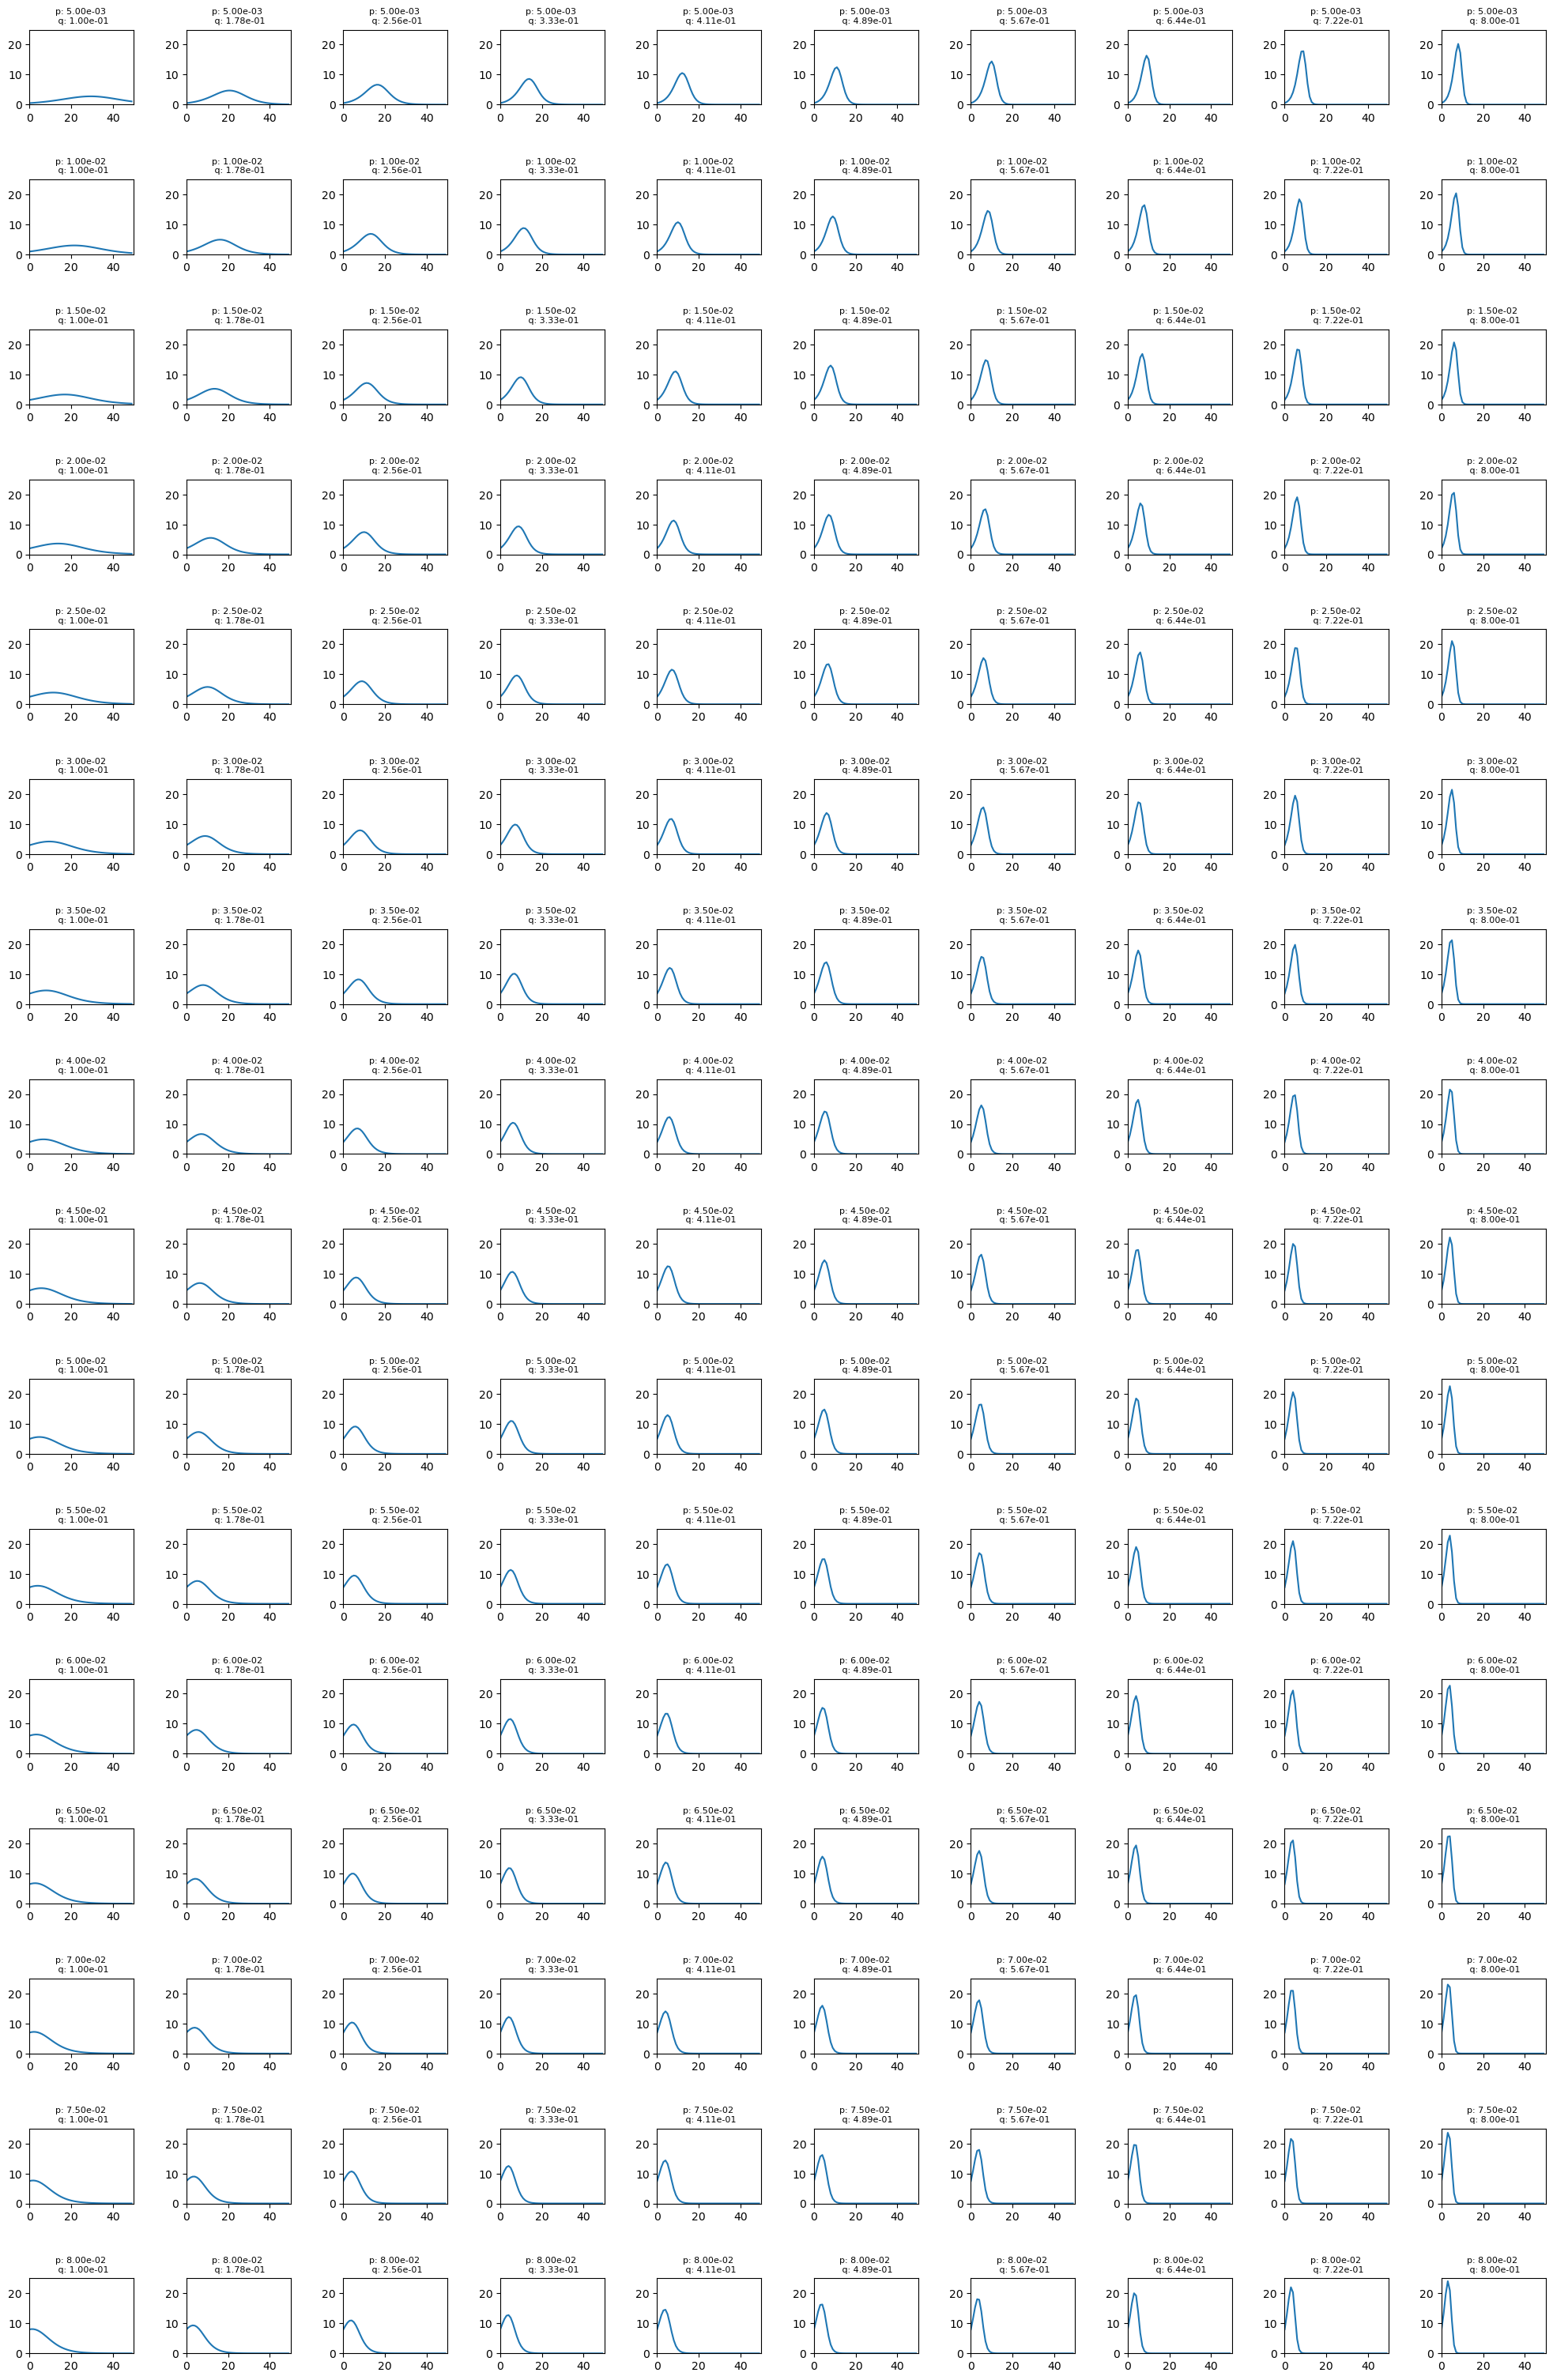

In [206]:
## Code written by me

# Setting random seed
np.random.seed(0)

# Creating arrays for trial values of p, q
P = np.linspace(0.005, 0.08, 16)
Q = np.linspace(0.1, 0.8, 10)
M = 100

# Plotting the graphs
fig, axs = plt.subplots(16, 10, figsize=(20, 30))
plt.tight_layout()
plt.subplots_adjust(hspace=1)
for p in P:
    for q in Q:
        # Creating arrays for t, n_t, a_t, a2_t
        tmax = 50
        t = np.arange(0, tmax, 1)
        n_t = np.zeros(tmax)
        a_t = np.zeros(tmax)

        # Computing true values of Bass Model
        n_t[0] = p*M
        a_t[0] = 0
        for k in range(1, tmax):
            a_t[k] = a_t[k-1] + n_t[k-1]
            n_t[k] = p*M + (q-p)*a_t[k] - q*a_t[k]**2/M
        axs[np.where(P == p)[0][0], np.where(Q == q)[0][0]].plot(t, n_t)
        axs[np.where(P == p)[0][0], np.where(Q == q)[0][0]].set_title(f'p: {p:.2e} \n q: {q:.2e}')
        axs[np.where(P == p)[0][0], np.where(Q == q)[0][0]].title.set_size(8)
        axs[np.where(P == p)[0][0], np.where(Q == q)[0][0]].set_xlim([0, 50])
        axs[np.where(P == p)[0][0], np.where(Q == q)[0][0]].set_ylim([0, 25])

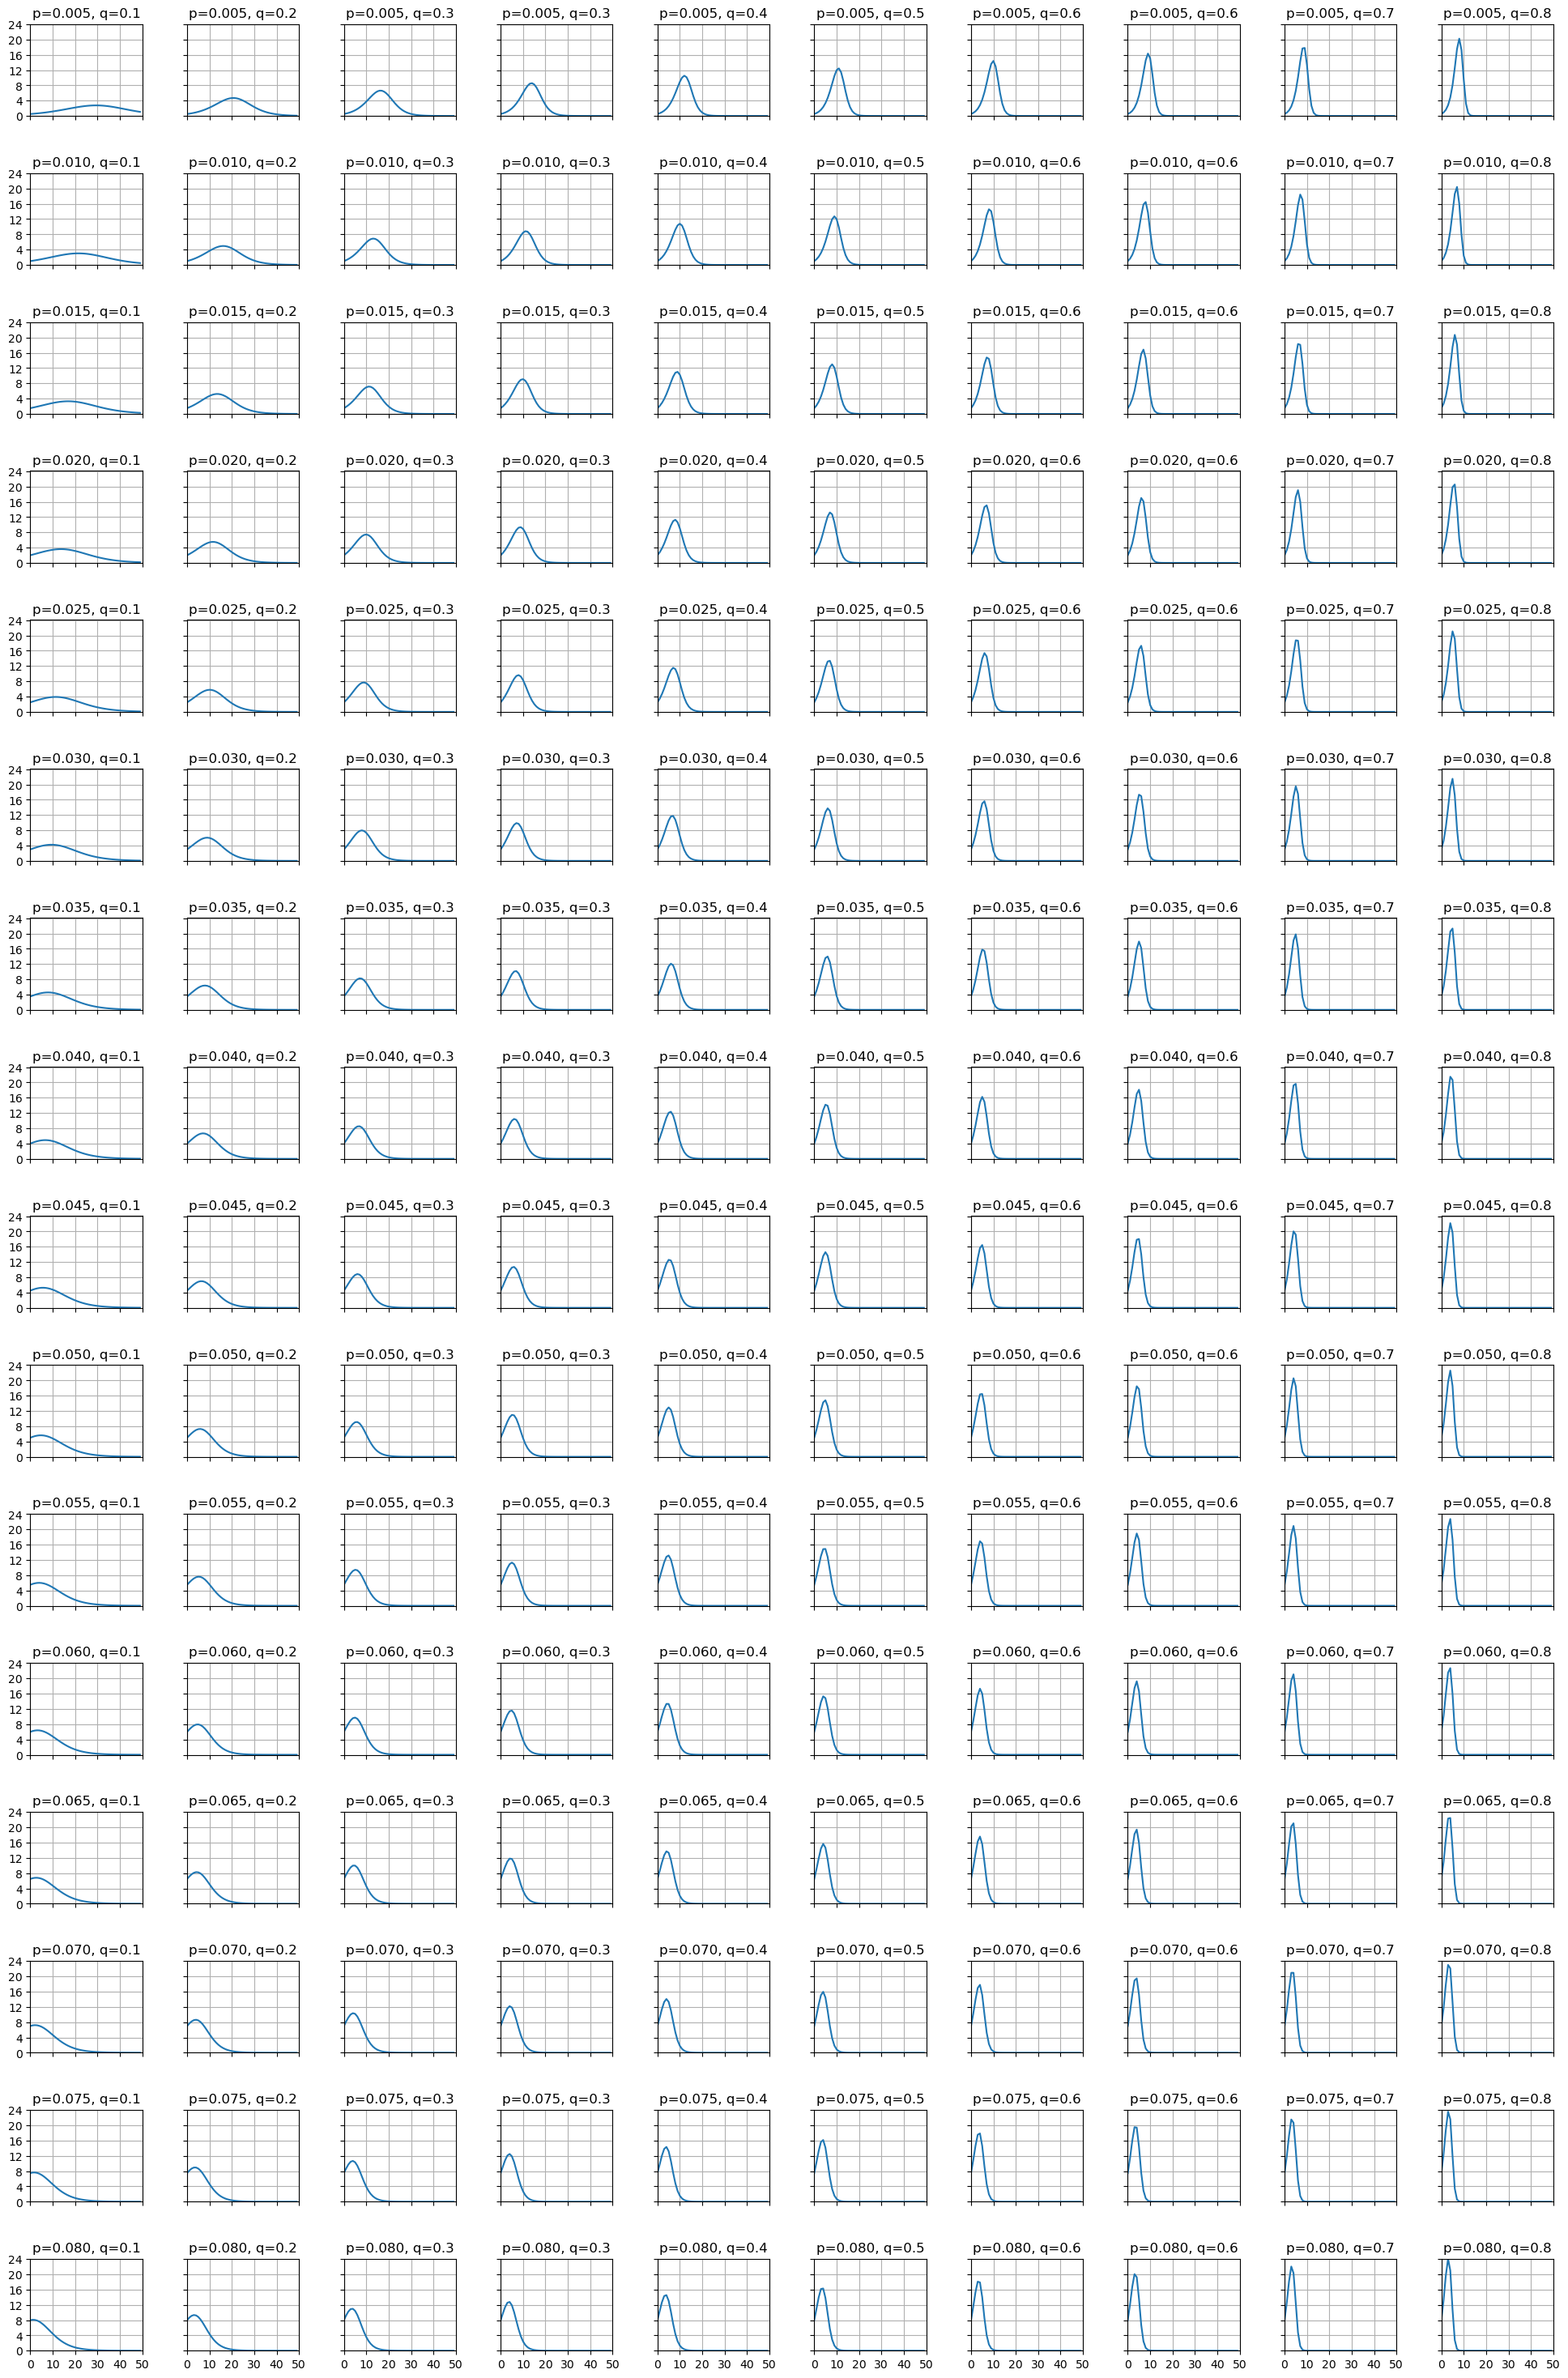

In [212]:
## Code generated by ChatGPT 3.5 based on the following prompt:

# In the Discrete Bass Diffusion Model, consider M (population) = 100. Provide python code for and plot the N(t) curves for 16 values of p (coefficient of imitation) ranging from 0.005 to 0.08 and 10 values of q ranging from 0.1 to 0.8. Make sure that all these subplots have a tight layout and are on the same x-scale (50) and y-scale (maximum value of N across all plots). Set vertical space in graphs to make sure they don't overlap. Provide some grid and ticks on the graph with values as well.
# Use the following steps:
# 	1	Choose minimum value of p and minimum value of q
# 	2	Compute the bass diffusion series N(1), N(2) … N(50) for these values of p and q and M = 100. This can be achieved by first setting initial N (number of adopters) to p*M and initial A (cumulative adopters) to 0. Then iteratively, we find A(t) = A(t-1) + N(t-1). We find N(t) = p*M + (q-p)A(t) - q*A(t)^2/M. Finally, plot this series on a graph N vs t.
# 	3	Choose a higher value of q for the same p and repeat step 2 till you reach maximum value of q.
# 	4	Choose a higher value of p and repeat steps 1-3 till you reach maximum value of q.

import numpy as np
import matplotlib.pyplot as plt

# Function to compute the Bass diffusion series
def bass_diffusion_series(p, q, M=100):
    N = np.zeros(50)
    A = np.zeros(50)
    N[0] = p * M
    A[0] = 0
    for t in range(1, 50):
        A[t] = A[t-1] + N[t-1]
        N[t] = p * M + (q - p) * A[t] - q * (A[t] ** 2) / M
    return N

# Define values of p and q
p_values = np.linspace(0.005, 0.08, 16)
q_values = np.linspace(0.1, 0.8, 10)

# Create subplots
fig, axs = plt.subplots(len(p_values), len(q_values), figsize=(20, 30), sharex=True, sharey=True)

# Initialize maximum value of N
max_N = 0

# Generate plots
for i, p in enumerate(p_values):
    for j, q in enumerate(q_values):
        N = bass_diffusion_series(p, q)
        axs[i, j].plot(N)
        axs[i, j].set_title(f'p={p:.3f}, q={q:.1f}')
        axs[i, j].set_xlim(0, 50)
        max_N = max(max_N, np.max(N))

# Set y-axis limit for all plots
for ax in axs.flat:
    ax.set_ylim(0, max_N)
    ax.grid(True)

# Set ticks
for ax in axs.flat:
    ax.set_xticks(np.arange(0, 51, 10))
    ax.set_yticks(np.arange(0, max_N+1, max_N//5))

# Adjust layout
plt.tight_layout(pad=3.0)
plt.show()

(Q3) Comparing Slides 12,13 with Slides 14,15, we see that the estimation error of M is larger  in the first case than in the second case, and consequently the forecasted curve beyond period 15 is much further from the true curve in the first case than in the second case.  What differences in the two time series or the nature of the noise (up to period 15) lead to the difference  described in the previous sentence? The main point of this question is not to tie you specifically to the examples on the slides but to make you think more broadly about the situations in the data or problem that lead to M being estimated poorly.  If you want, you can experiment with different values of p,q, different levels of noise and compare the forecasted curve with noise with the forecasted curve without noise as slides 14 and 16 do, or compute the magnitude of error in the estimated value of M.  This question is open ended, with a response ranging from 2 sentences to 3 pages. Points  will be accrued in proportion to the depth of analysis.

Details and suggestions on how to proceed: You need to do what we did in slides 12 through 15 but for a larger set. Specifically, you consider different sets of values of p,q. For each set, you compute the true values N(1), N(2)...through N(Tmax) for some moderately large value of Tmax like 50, and inspect the curve. These are taken to be true values from the Bass model. So far this is the same as in the suggestions for Q2 above, but now the difference begins. We consider the situation like we typically encounter in real life, where we do not know the true values of p,q or the N() values,  we instead observe only N() values up to period 14, and that too only noisy or "shuffled" versions of these N() values. So we have to create modified values of the N() values by taking N(1), N(2), ... up to N(14) and adding some noise. This is what we did to go from the "original" column in Slide 12 or Slide 14 to the corresponding "shuffled" column. Then we assume that the "shuffled" data are the only dataset we have, and we  estimate p,q from this dataset. Then we extrapolate the shuffled data using the estimated p, q, and the shuffled N(14) and A(14) and the Bass Model recursive equations (Slide 4) to future periods to get estimates of the number of adopters in periods N(15), N(16),.. through N(TMax). Finally, we compare these to the true values of N(15), N(16),... N(TMax). This comparison is what we are doing in Slides 13 and 15. The extrapolated values based on the shuffled data are plotted as the dashed line, and the true values are plotted as the solid line.  Clearly, the extrapolation is more accurate in Slide 15 than in Slide 13. You need to try different sets of p, q, and recognized general patterns in when the extrapolation is more accurate and when it is less accurate. To make the analysis simpler, I suggest you keep the level and type of noise to be fixed: so you would just add 10% noise to the data multiplying each true N with a uniform random number between 0.9 and 1.1.

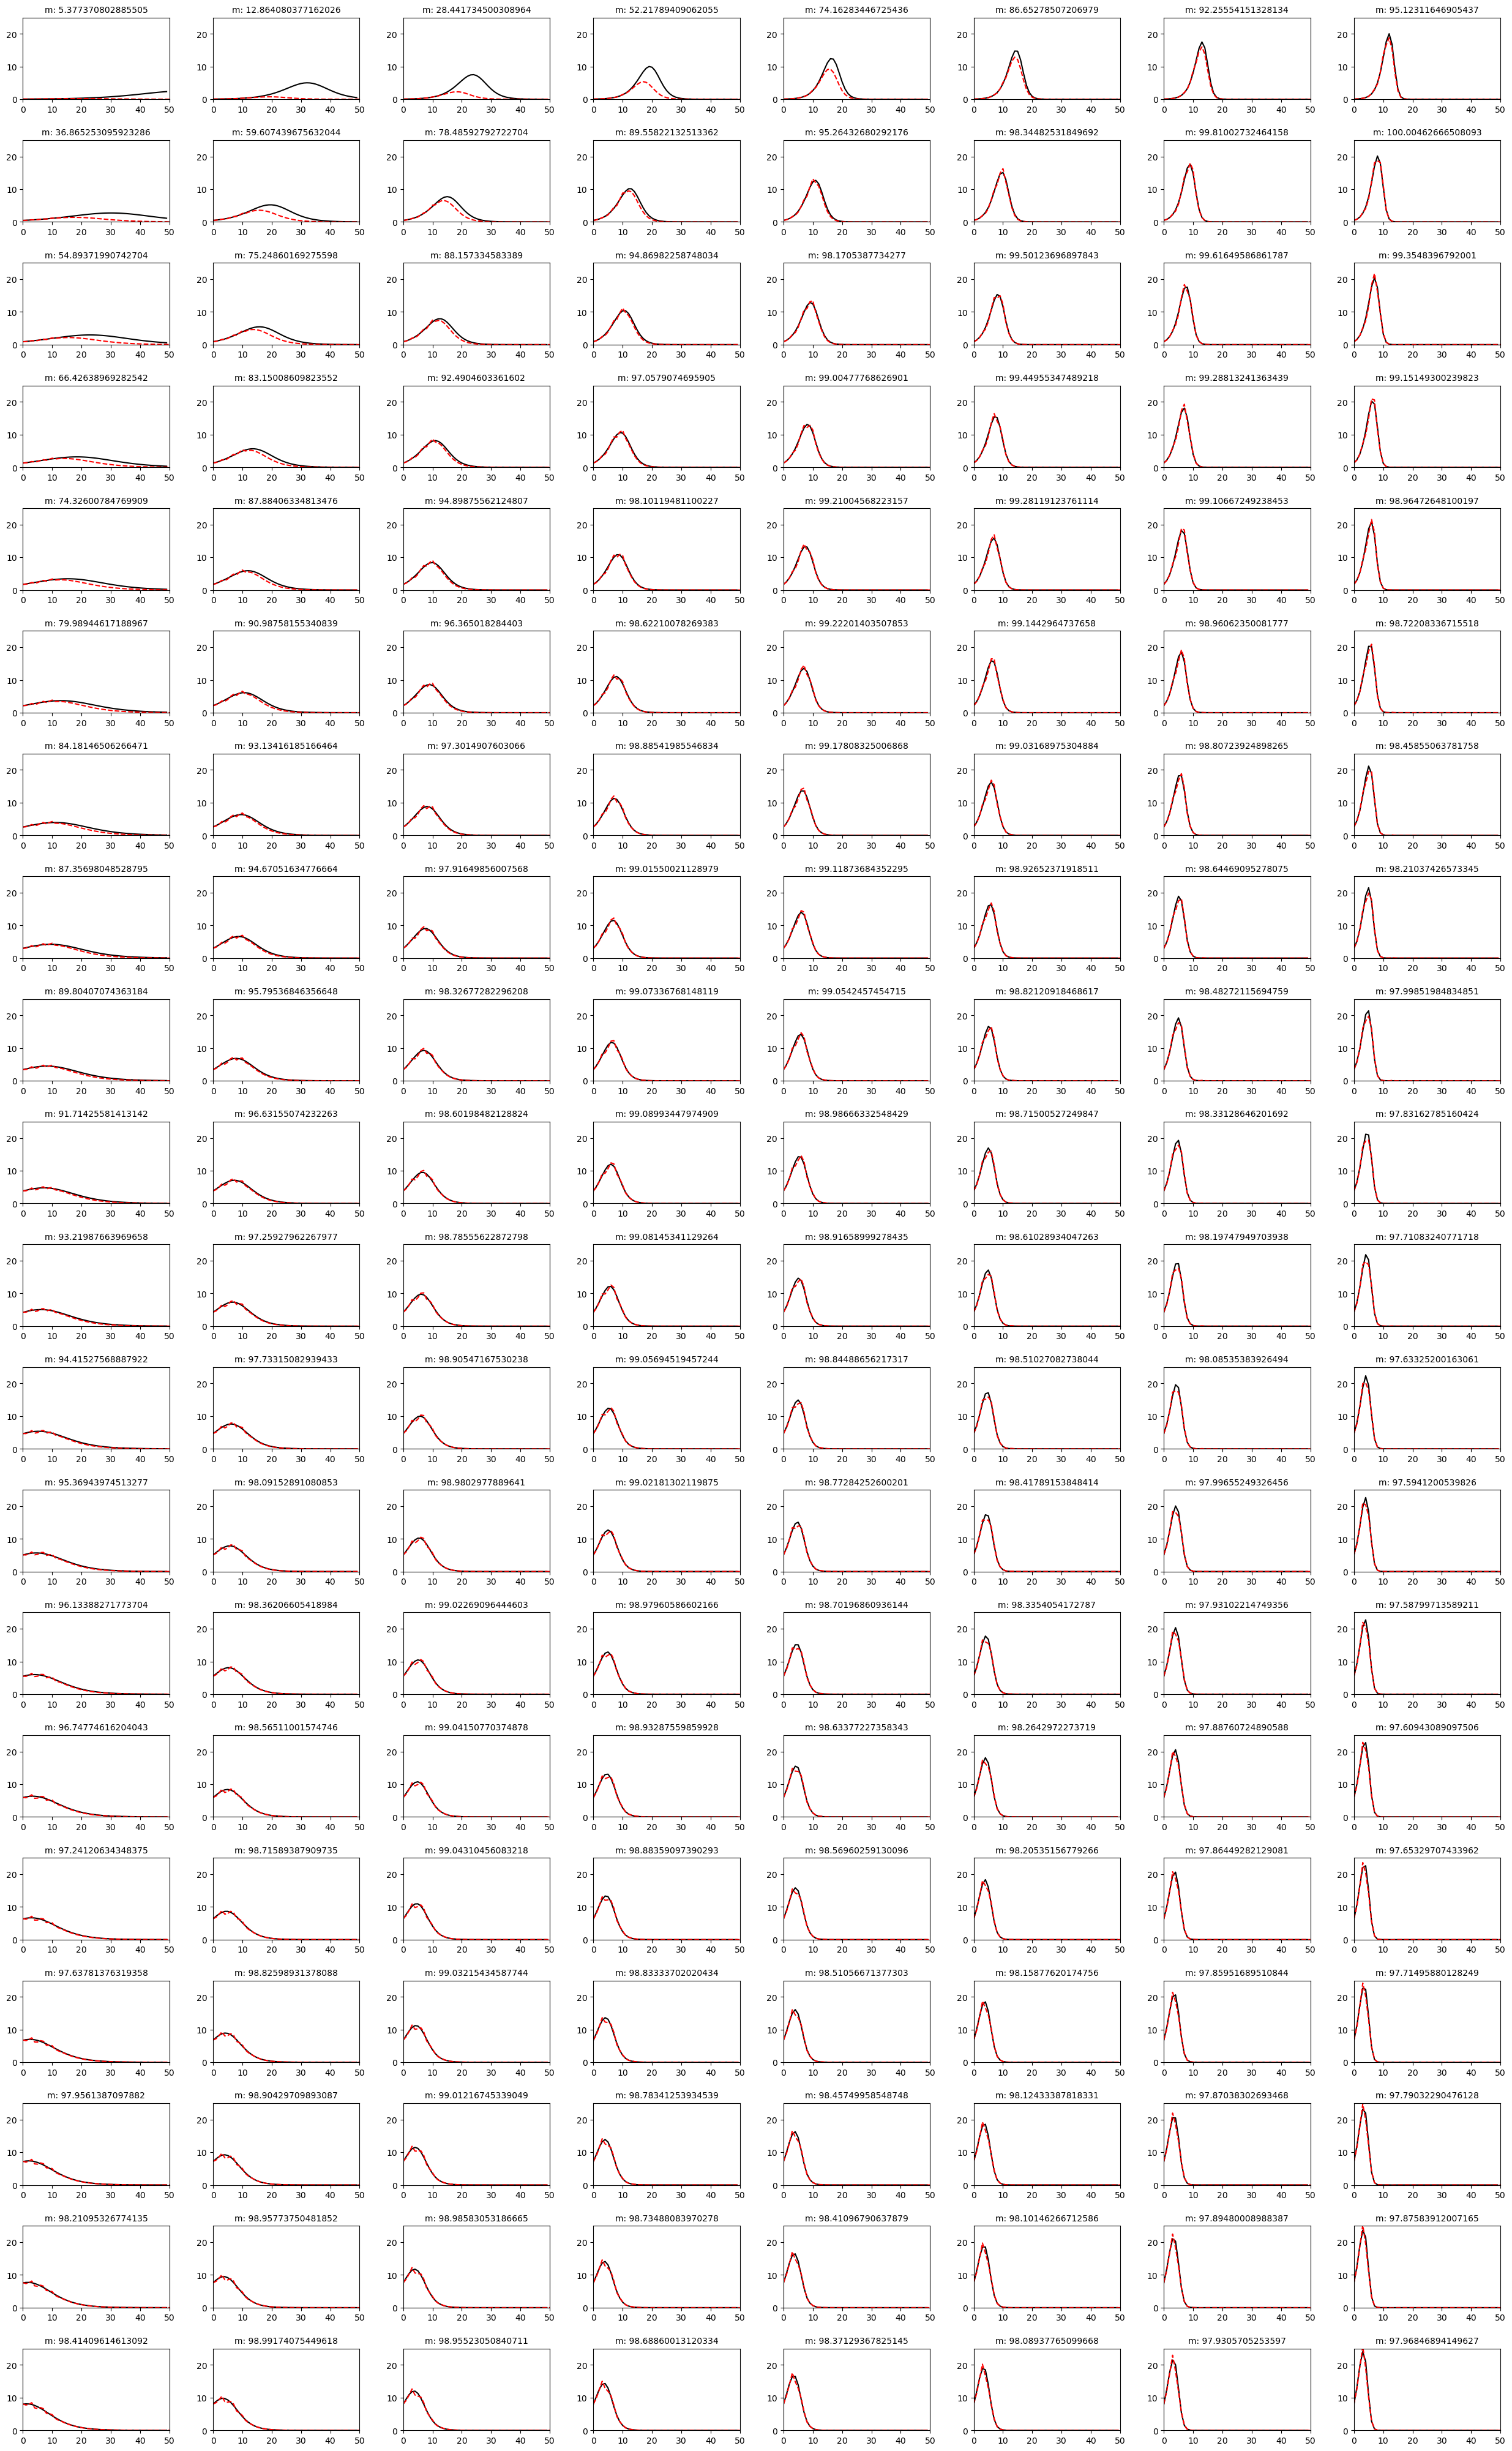

In [284]:
# Setting random seed
np.random.seed(100)

#create array of 14 random numbers uniformly distributed between 0.9 and 1.1
noise = np.random.uniform(0.9, 1.1, 14)

# Creating arrays for trial values of p, q
P = np.linspace(0.0005, 0.08, 20)
Q = np.linspace(0.1, 0.8, 8)
M = 100

# Plotting the graphs
fig, axs = plt.subplots(20, 8, figsize=(25, 40))
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
for p in P:
    for q in Q:

        # Creating arrays for true values of Bass Model
        tmax = 50
        t = np.arange(0, tmax, 1)
        n_t = np.zeros(tmax)
        a_t = np.zeros(tmax)

        # Computing true values of Bass Model
        n_t[0] = p*M
        a_t[0] = 0
        for k in range(1, tmax):
            a_t[k] = a_t[k-1] + n_t[k-1]
            n_t[k] = p*M + (q-p)*a_t[k] - q*a_t[k]**2/M

        # Creating a new dataframe for shuffled data
        tmod = np.arange(0, 14, 1)
        nmod_t = np.zeros(14)
        df = pd.DataFrame({'t': tmod, 'n_t': nmod_t})

        ## Estimating the Bass Model using shuffled data
        # Shuffling the data
        for k in range(0, 14):
            df.n_t[k] = n_t[k] * noise[k]

        # Creating adoption series A(t) and A(t)^2
        df['a_t'] = df['n_t'].cumsum()
        df['a_t'] = df['a_t'].shift(1)
        df.fillna(0, inplace=True)
        df['a2_t'] = df['a_t']**2

        # Fit an ols model
        model = ols('n_t ~ a_t + a2_t', data = df).fit()
        #print(model.summary())

        #Finding p, q, M
        a = model.params['Intercept']
        b = model.params['a_t']
        c = model.params['a2_t']

        p_hat = (np.sqrt(b**2 - 4 * a * c) - b)/2
        q_hat = (np.sqrt(b**2 - 4 * a * c) + b)/2
        M_hat = -q_hat/c
        
        # Adding new rows to the dataframe
        for i in range(14, tmax+1):
            df = pd.concat([df, pd.DataFrame({'t': [i], 'n_t': [0], 'a_t': [0], 'a2_t': [0]})], ignore_index=True)
            df.loc[i-1, 'a_t'] = df.loc[i-2, 'n_t'] + df.loc[i-2, 'a_t']
            df.loc[i-1, 'a2_t'] = df.loc[i-1, 'a_t']**2
            df.loc[i-1, 'n_t'] = a + b*df.loc[i-1, 'a_t'] + c*df.loc[i-1, 'a2_t']

        axs[np.where(P == p)[0][0], np.where(Q == q)[0][0]].plot(t, n_t, color='black')
        axs[np.where(P == p)[0][0], np.where(Q == q)[0][0]].plot(df.t, df.n_t, linestyle='--', color='red')
        axs[np.where(P == p)[0][0], np.where(Q == q)[0][0]].set_title(f'm: {M_hat}')
        axs[np.where(P == p)[0][0], np.where(Q == q)[0][0]].title.set_size(10)
        axs[np.where(P == p)[0][0], np.where(Q == q)[0][0]].set_xlim([0, 50])
        axs[np.where(P == p)[0][0], np.where(Q == q)[0][0]].set_ylim([0, 25])

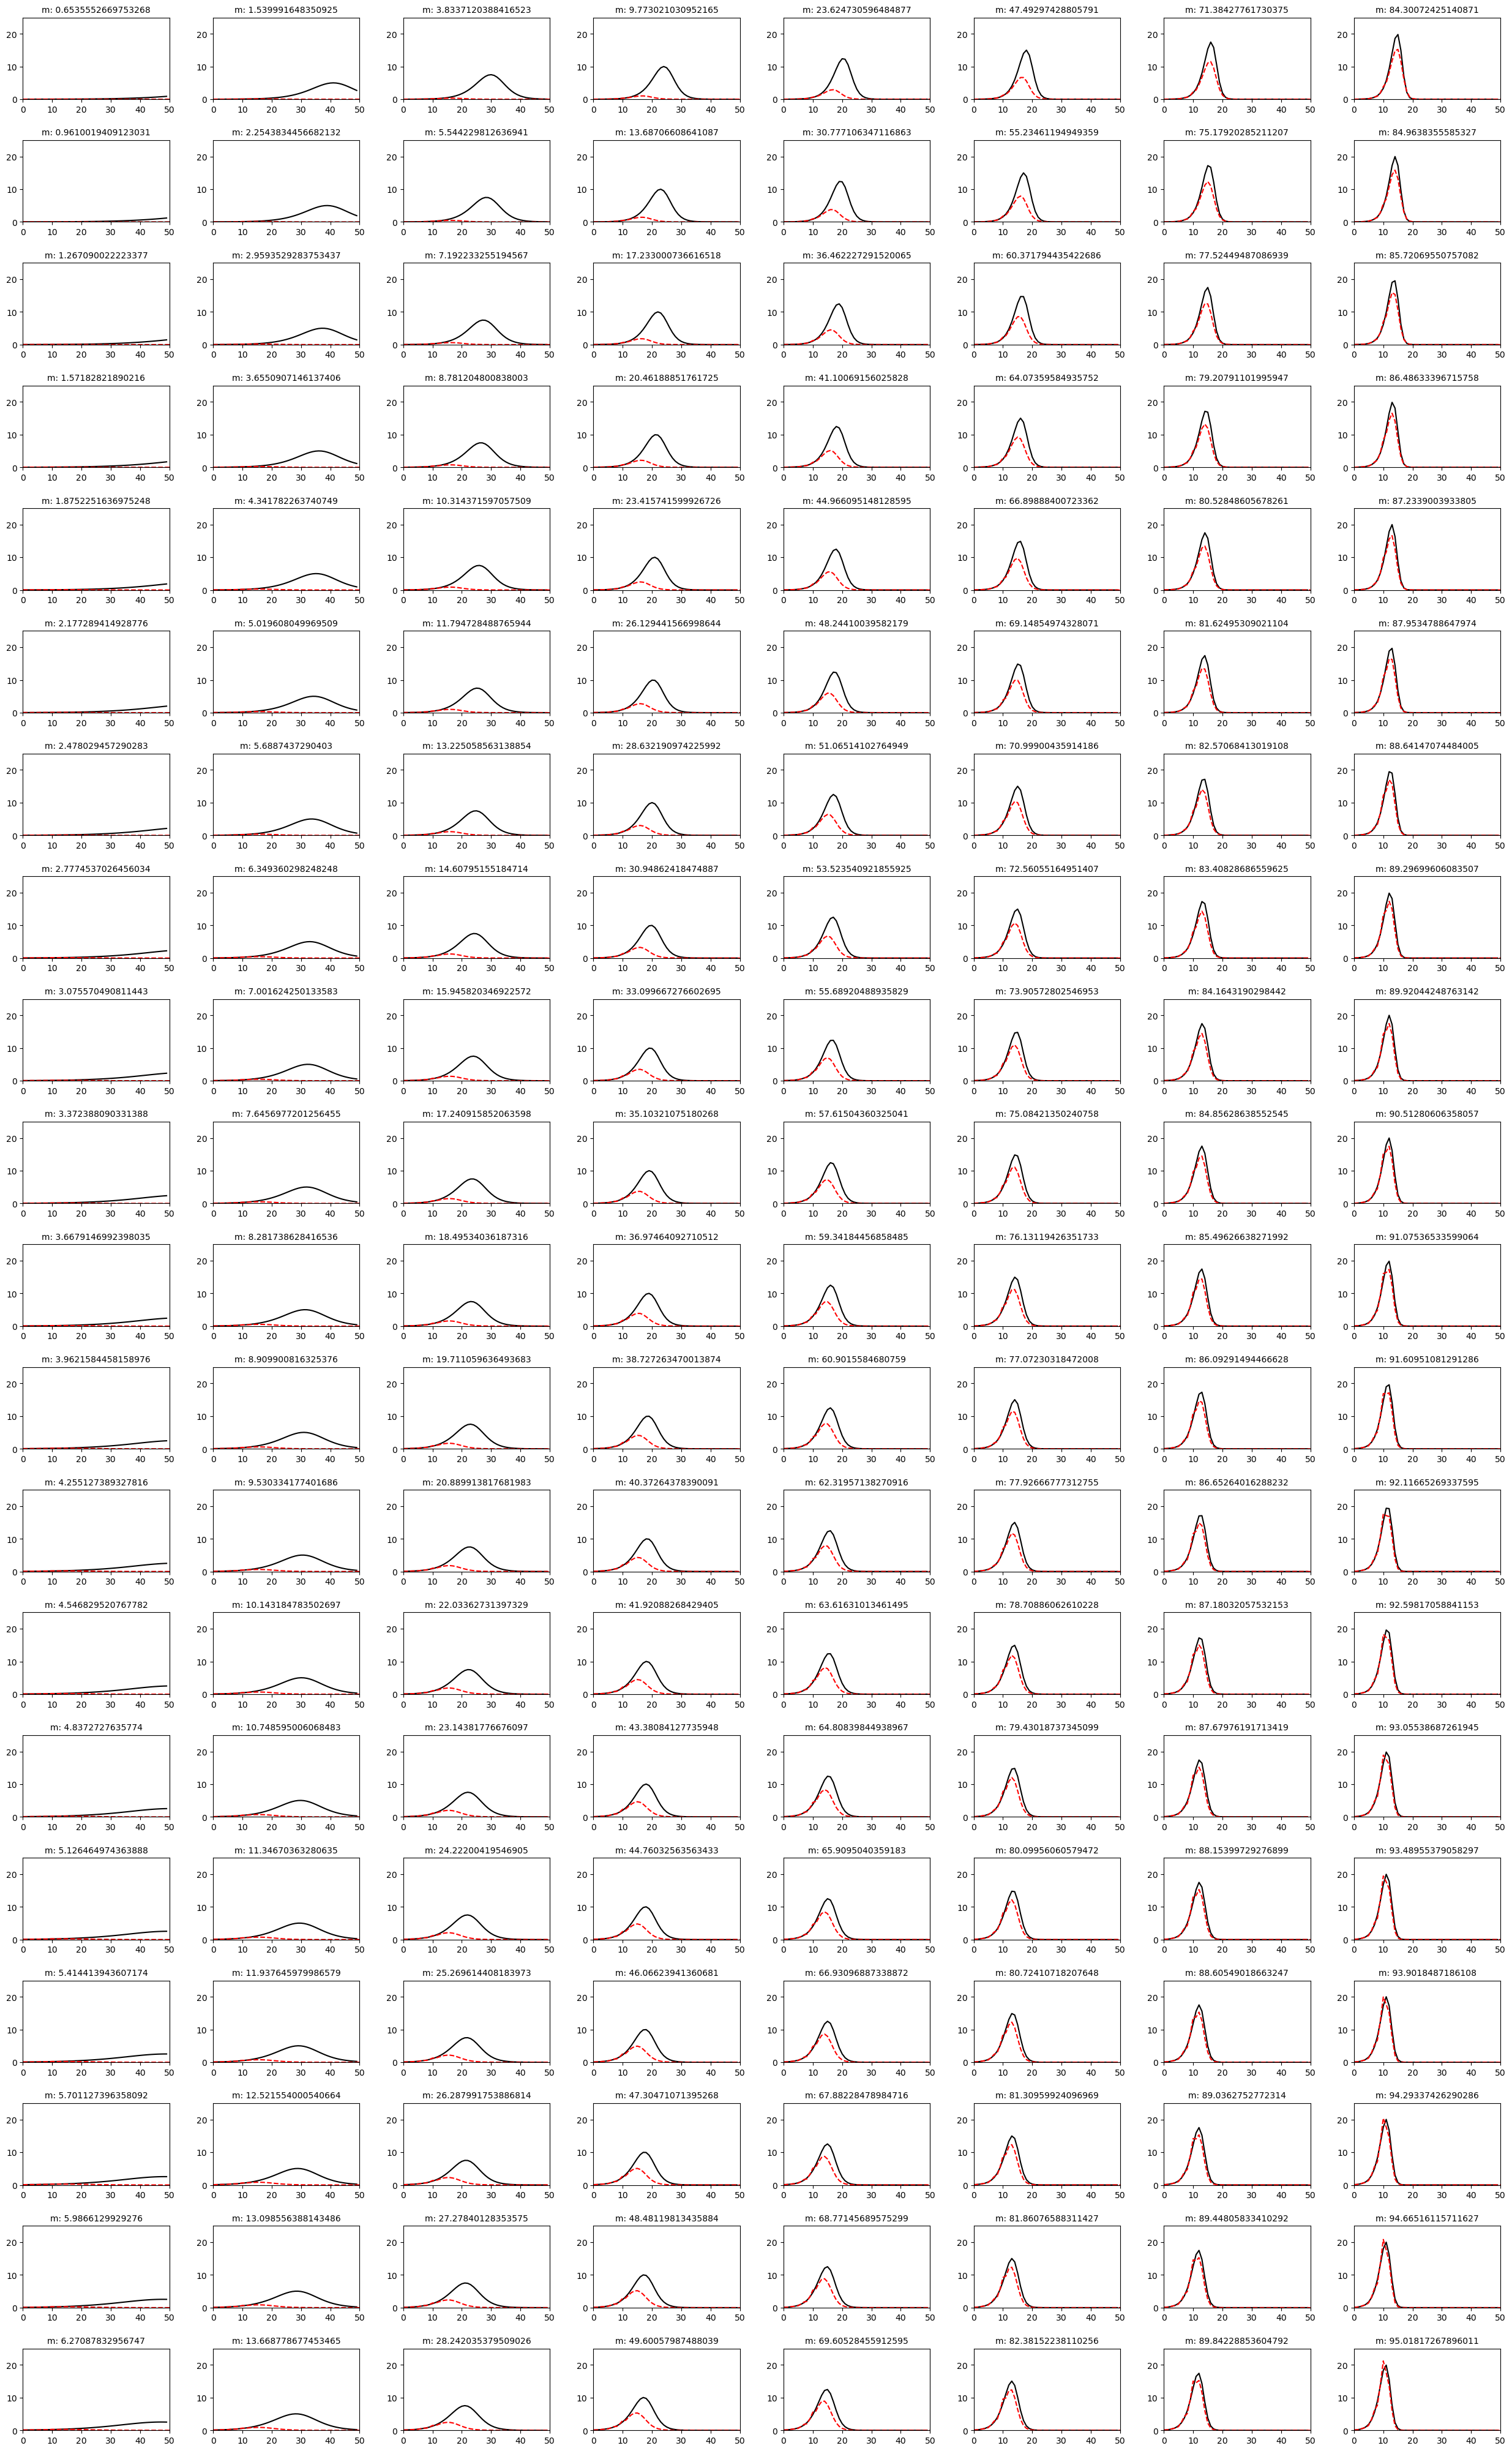

In [282]:
# Setting random seed
np.random.seed(100)

#create array of 14 random numbers uniformly distributed between 0.9 and 1.1
noise = np.random.uniform(0.8, 1.2, 14)

# Creating arrays for trial values of p, q
P = np.linspace(0.0001, 0.001, 20)
Q = np.linspace(0.1, 0.8, 8)
M = 100

# Plotting the graphs
fig, axs = plt.subplots(20, 8, figsize=(25, 40))
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
for p in P:
    for q in Q:

        # Creating arrays for true values of Bass Model
        tmax = 50
        t = np.arange(0, tmax, 1)
        n_t = np.zeros(tmax)
        a_t = np.zeros(tmax)

        # Computing true values of Bass Model
        n_t[0] = p*M
        a_t[0] = 0
        for k in range(1, tmax):
            a_t[k] = a_t[k-1] + n_t[k-1]
            n_t[k] = p*M + (q-p)*a_t[k] - q*a_t[k]**2/M

        # Creating a new dataframe for shuffled data
        tmod = np.arange(0, 14, 1)
        nmod_t = np.zeros(14)
        df = pd.DataFrame({'t': tmod, 'n_t': nmod_t})

        ## Estimating the Bass Model using shuffled data
        # Shuffling the data
        for k in range(0, 14):
            df.n_t[k] = n_t[k] * noise[k]

        # Creating adoption series A(t) and A(t)^2
        df['a_t'] = df['n_t'].cumsum()
        df['a_t'] = df['a_t'].shift(1)
        df.fillna(0, inplace=True)
        df['a2_t'] = df['a_t']**2

        # Fit an ols model
        model = ols('n_t ~ a_t + a2_t', data = df).fit()
        #print(model.summary())

        #Finding p, q, M
        a = model.params['Intercept']
        b = model.params['a_t']
        c = model.params['a2_t']

        p_hat = (np.sqrt(b**2 - 4 * a * c) - b)/2
        q_hat = (np.sqrt(b**2 - 4 * a * c) + b)/2
        M_hat = -q_hat/c
        
        # Adding new rows to the dataframe
        for i in range(14, tmax+1):
            df = pd.concat([df, pd.DataFrame({'t': [i], 'n_t': [0], 'a_t': [0], 'a2_t': [0]})], ignore_index=True)
            df.loc[i-1, 'a_t'] = df.loc[i-2, 'n_t'] + df.loc[i-2, 'a_t']
            df.loc[i-1, 'a2_t'] = df.loc[i-1, 'a_t']**2
            df.loc[i-1, 'n_t'] = a + b*df.loc[i-1, 'a_t'] + c*df.loc[i-1, 'a2_t']

        axs[np.where(P == p)[0][0], np.where(Q == q)[0][0]].plot(t, n_t, color='black')
        axs[np.where(P == p)[0][0], np.where(Q == q)[0][0]].plot(df.t, df.n_t, linestyle='--', color='red')
        axs[np.where(P == p)[0][0], np.where(Q == q)[0][0]].set_title(f'm: {M_hat}')
        axs[np.where(P == p)[0][0], np.where(Q == q)[0][0]].title.set_size(10)
        axs[np.where(P == p)[0][0], np.where(Q == q)[0][0]].set_xlim([0, 50])
        axs[np.where(P == p)[0][0], np.where(Q == q)[0][0]].set_ylim([0, 25])

(Q4) A model is a linear regression model when the number of predictors (including the constant column of 1s) is equal to the number of parameters to be estimated and there is a one-to-one mapping between the coefficients and the parameters to be estimated. If this condition fails to hold then it is a nonlinear regression. Linear regression does not necessarily mean that the plot between X and expected Y looks like a straight line.  In the equation N(t) = M*p + (q-p)*A(t) - (q/M)*A^2(t), if M is not fixed then there are three parameters (p,q,M) and three predictors including the intercept, and also there is a  one-to-one mapping, so this is a linear regression. In that same equation, if M is fixed then there are only two parameters and still three predictors, and so it becomes a nonlinear regression. Note, however, that in some cases, it is possible to modify the expression in a nonlinear regression situation to bring it to a linear regression situation, and indeed that modification is possible in the case of N(t) = M*p + (q-p)*A(t) - (q/M)*A^2(t) with M fixed as we do in Question Q1.2. What is that modification? Another way to ask this question: What are the predictors you will use in the post-modification linear regression? How do you get the values of p and q from the coefficients of this linear regression? Run the corresponding linear regression and verify that you get the same p and q values as in Question Q1.2. This question is about the discrete Bass and not continuous Bass.

In [290]:
# Load the data
df = pd.read_csv('adoption_series2.csv')

df = df[['t', 'N(t)']]
df.columns = ['t', 'n_t']

# Fixing M at 100
M = 100

# Creating adoption series A(t) and A(t)^2
df['a_t'] = df['n_t'].cumsum()
df['a_t'] = df['a_t'].shift(1)
df.fillna(0, inplace=True)

df['r_t'] = M - df['a_t']
df['y'] = df['n_t'] / df['r_t']

# Fit an ols model
model = ols('y ~ a_t', data = df).fit()
#print(model.summary())

#Finding p, q, M
a = model.params['Intercept']
b = model.params['a_t']

p = a
q = b*M

# Adding new rows to the dataframe
for i in range(15, 31):
    df = pd.concat([df, pd.DataFrame({'t': [i], 'n_t': [0], 'a_t': [0], 'a2_t': [0]})], ignore_index=True)
    df.loc[i-1, 'a_t'] = df.loc[i-2, 'n_t'] + df.loc[i-2, 'a_t']
    df.loc[i-1, 'y'] = a + b*df.loc[i-1, 'a_t']
    df.loc[i-1, 'r_t'] = M - df.loc[i-1, 'a_t']
    df.loc[i-1, 'n_t'] = df.loc[i-1, 'y'] * df.loc[i-1, 'r_t']

# Significant digits
p = float('%.*g' % (3, p))
q = float('%.*g' % (3, q))
M = float('%.*g' % (3, M))
N_30 = float('%.*g' % (3, df.loc[29, 'n_t']))

# Print final deliverable values
print(f'p = {p}, q = {q}, M = {M}, N(30) = {N_30}')

p = 0.00106, q = 0.194, M = 100.0, N(30) = 4.89
